Retirado de: https://www.kaggle.com/datasets/meirnizri/covid19-dataset

## Importanto dependencias

In [1]:
#!pip install -q catboost
#!pip install -q xgboost
#!pip install -q shap

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Métricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# SHAP
import shap
import statistics

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Lendo CSV

In [3]:
# Montando drive
#drive.mount('/content/drive')
#filename = '/content/drive/MyDrive/BSI/2023-2/PD2/Datasets/covid_mexico.csv'

# Local
filename = "./data/covid_mexico.csv"
covid_df = pd.read_csv(filename)

In [4]:
covid_df.shape

(1048575, 21)

In [5]:
covid_df.head()

USMER  MEDICAL_UNIT  SEX  PATIENT_TYPE   DATE_DIED  INTUBED  PNEUMONIA  \
0      2             1    1             1  03/05/2020       97          1   
1      2             1    2             1  03/06/2020       97          1   
2      2             1    2             2  09/06/2020        1          2   
3      2             1    1             1  12/06/2020       97          2   
4      2             1    2             1  21/06/2020       97          2   

   AGE  PREGNANT  DIABETES  ...  ASTHMA  INMSUPR  HIPERTENSION  OTHER_DISEASE  \
0   65         2         2  ...       2        2             1              2   
1   72        97         2  ...       2        2             1              2   
2   55        97         1  ...       2        2             2              2   
3   53         2         2  ...       2        2             2              2   
4   68        97         1  ...       2        2             1              2   

   CARDIOVASCULAR  OBESITY  RENAL_CHRONIC  TOBACCO  CLASIFFICATION_FINAL  ICU  
0               2        2              2        2                     3   97  
1               2        1              1        2                     5   97  
2               2        2              2        2                     3    2  
3               2        2              2        2                     7   97  
4               2        2              2        2                     3   97  

[5 rows x 21 columns]

In [6]:
covid_df.describe()

USMER  MEDICAL_UNIT           SEX  PATIENT_TYPE       INTUBED  \
count  1.048575e+06  1.048575e+06  1.048575e+06  1.048575e+06  1.048575e+06   
mean   1.632194e+00  8.980565e+00  1.499259e+00  1.190765e+00  7.952288e+01   
std    4.822084e-01  3.723278e+00  4.999997e-01  3.929041e-01  3.686889e+01   
min    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
25%    1.000000e+00  4.000000e+00  1.000000e+00  1.000000e+00  9.700000e+01   
50%    2.000000e+00  1.200000e+01  1.000000e+00  1.000000e+00  9.700000e+01   
75%    2.000000e+00  1.200000e+01  2.000000e+00  1.000000e+00  9.700000e+01   
max    2.000000e+00  1.300000e+01  2.000000e+00  2.000000e+00  9.900000e+01   

          PNEUMONIA           AGE      PREGNANT      DIABETES          COPD  \
count  1.048575e+06  1.048575e+06  1.048575e+06  1.048575e+06  1.048575e+06   
mean   3.346831e+00  4.179410e+01  4.976558e+01  2.186404e+00  2.260569e+00   
std    1.191288e+01  1.690739e+01  4.751073e+01  5.424242e+00  5.132258e+00   
min    1.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
25%    2.000000e+00  3.000000e+01  2.000000e+00  2.000000e+00  2.000000e+00   
50%    2.000000e+00  4.000000e+01  9.700000e+01  2.000000e+00  2.000000e+00   
75%    2.000000e+00  5.300000e+01  9.700000e+01  2.000000e+00  2.000000e+00   
max    9.900000e+01  1.210000e+02  9.800000e+01  9.800000e+01  9.800000e+01   

             ASTHMA       INMSUPR  HIPERTENSION  OTHER_DISEASE  \
count  1.048575e+06  1.048575e+06  1.048575e+06   1.048575e+06   
mean   2.242626e+00  2.298132e+00  2.128989e+00   2.435143e+00   
std    5.114089e+00  5.462843e+00  5.236397e+00   6.646676e+00   
min    1.000000e+00  1.000000e+00  1.000000e+00   1.000000e+00   
25%    2.000000e+00  2.000000e+00  2.000000e+00   2.000000e+00   
50%    2.000000e+00  2.000000e+00  2.000000e+00   2.000000e+00   
75%    2.000000e+00  2.000000e+00  2.000000e+00   2.000000e+00   
max    9.800000e+01  9.800000e+01  9.800000e+01   9.800000e+01   

       CARDIOVASCULAR       OBESITY  RENAL_CHRONIC       TOBACCO  \
count    1.048575e+06  1.048575e+06   1.048575e+06  1.048575e+06   
mean     2.261810e+00  2.125176e+00   2.257180e+00  2.214333e+00   
std      5.194850e+00  5.175445e+00   5.135354e+00  5.323097e+00   
min      1.000000e+00  1.000000e+00   1.000000e+00  1.000000e+00   
25%      2.000000e+00  2.000000e+00   2.000000e+00  2.000000e+00   
50%      2.000000e+00  2.000000e+00   2.000000e+00  2.000000e+00   
75%      2.000000e+00  2.000000e+00   2.000000e+00  2.000000e+00   
max      9.800000e+01  9.800000e+01   9.800000e+01  9.800000e+01   

       CLASIFFICATION_FINAL           ICU  
count          1.048575e+06  1.048575e+06  
mean           5.305653e+00  7.955397e+01  
std            1.881165e+00  3.682307e+01  
min            1.000000e+00  1.000000e+00  
25%            3.000000e+00  9.700000e+01  
50%            6.000000e+00  9.700000e+01  
75%            7.000000e+00  9.700000e+01  
max            7.000000e+00  9.900000e+01

In [7]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

# Pré Tratamento

### Tratando DATE_DIED

In [8]:
#A Data "9999-99-99" significa que o paciente sobreviveu
covid_df['DATE_DIED'].value_counts()

DATE_DIED
9999-99-99    971633
06/07/2020      1000
07/07/2020       996
13/07/2020       990
16/06/2020       979
               ...  
24/11/2020         1
17/12/2020         1
08/12/2020         1
16/03/2021         1
22/04/2021         1
Name: count, Length: 401, dtype: int64

In [9]:
#Cria nova coluna binaria e preenche com os valores baseando na coluna DATE_DIED
covid_df['PASSED'] = [0 if l == '9999-99-99' else 1 for l in covid_df.DATE_DIED]

#Remove coluna denecessária
covid_df.drop(columns=["DATE_DIED"], inplace=True)

covid_df.PASSED.value_counts()

PASSED
0    971633
1     76942
Name: count, dtype: int64

# Explorando Dados

### Descrevendo DataFrame

In [10]:
for i in covid_df.columns:
    print(i,"----->", len(covid_df[i].unique()))

USMER -----> 2
MEDICAL_UNIT -----> 13
SEX -----> 2
PATIENT_TYPE -----> 2
INTUBED -----> 4
PNEUMONIA -----> 3
AGE -----> 121
PREGNANT -----> 4
DIABETES -----> 3
COPD -----> 3
ASTHMA -----> 3
INMSUPR -----> 3
HIPERTENSION -----> 3
OTHER_DISEASE -----> 3
CARDIOVASCULAR -----> 3
OBESITY -----> 3
RENAL_CHRONIC -----> 3
TOBACCO -----> 3
CLASIFFICATION_FINAL -----> 7
ICU -----> 4
PASSED -----> 2


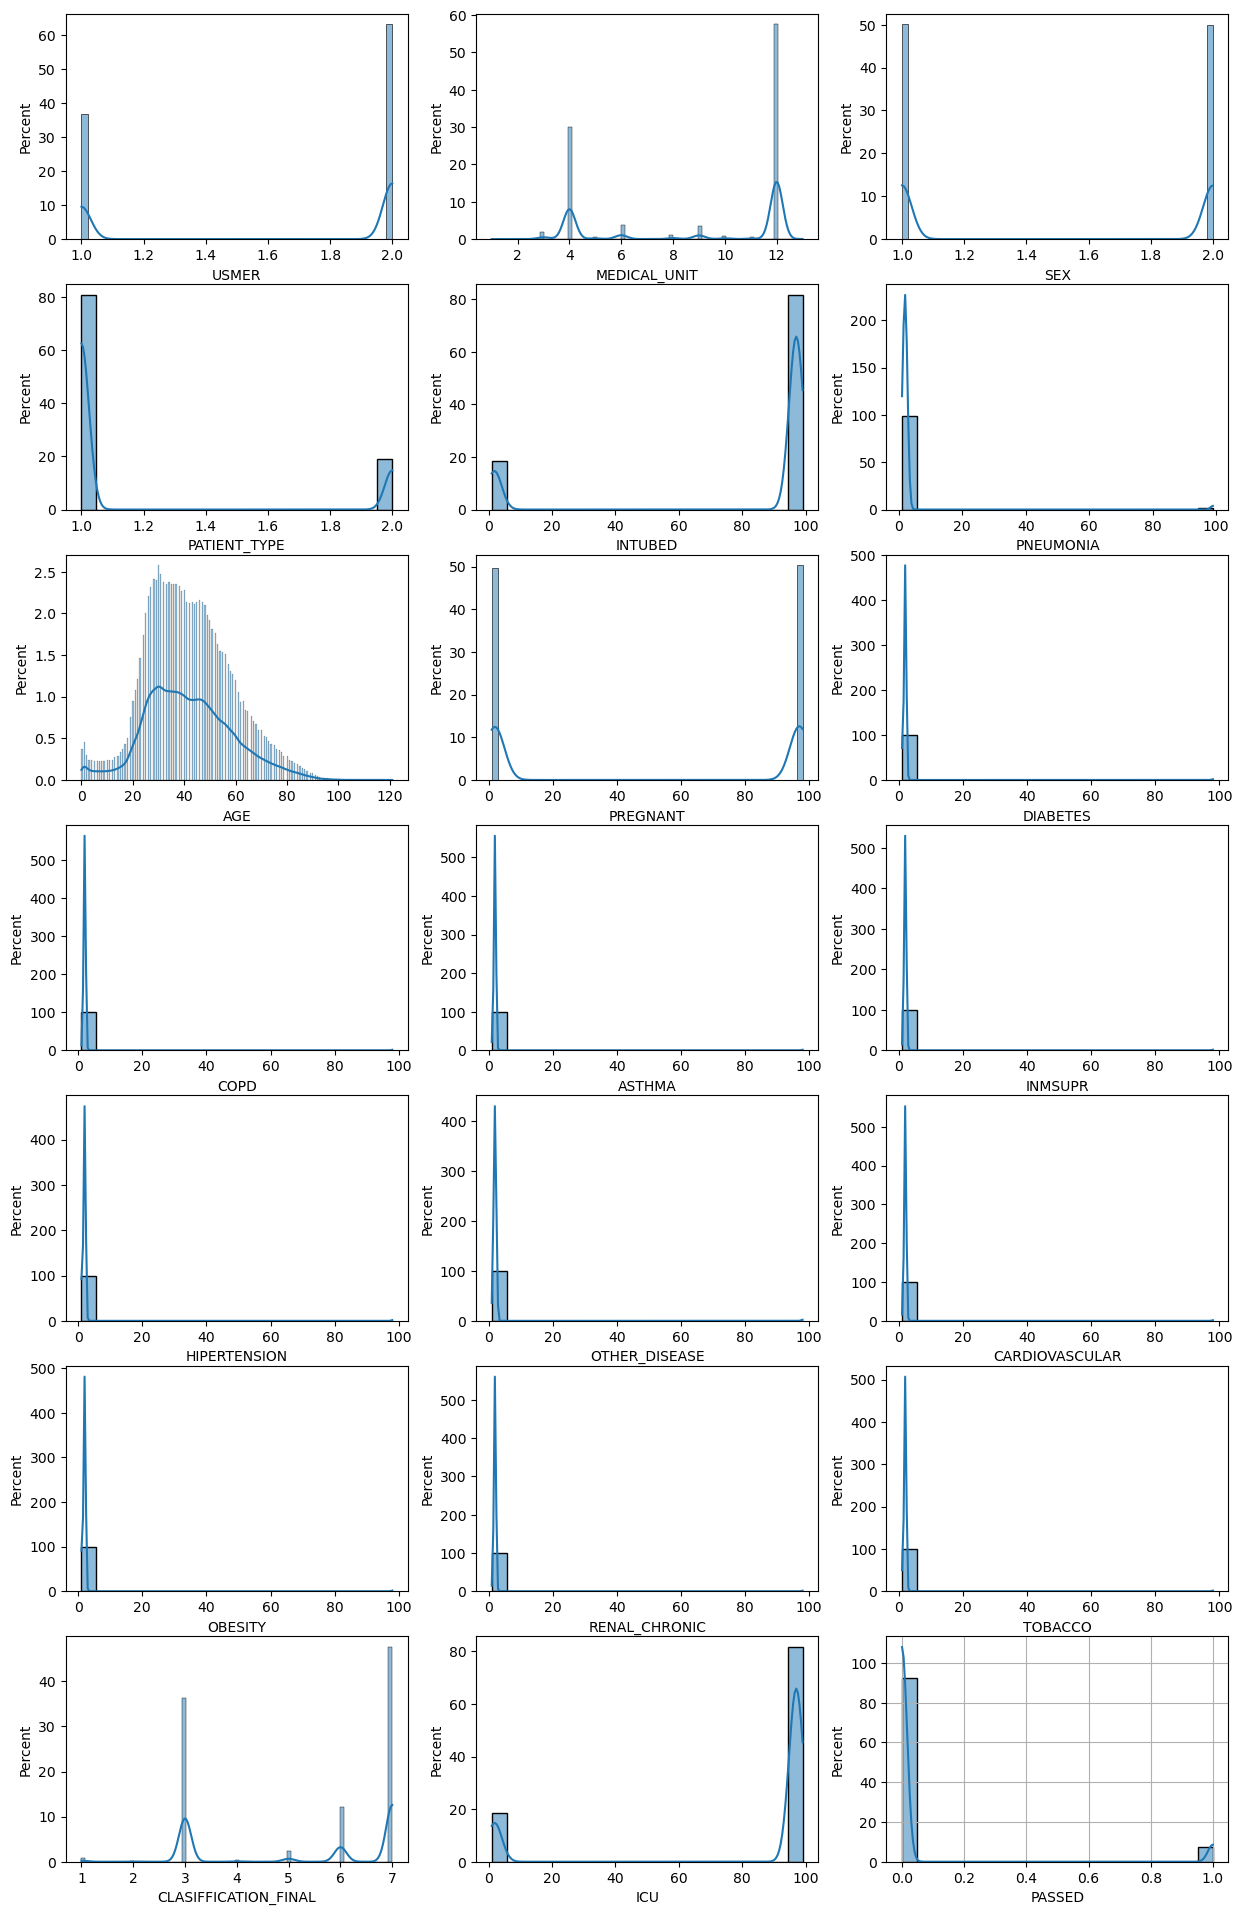

In [11]:
# HISTOGRAMA
plt.figure(figsize = (15, 24))

for i, col in enumerate(covid_df.columns):
    plt.subplot(7, 3, i+1)
    sns.histplot(covid_df.iloc[:, i], kde=True, stat='percent')

plt.grid()

### Percentual de Mortes

In [12]:
def plot_percentual_deads(df):
    percentual_deads = round(df.PASSED.mean() * 100, 2)
    print(f"Percentural of deads {percentual_deads}]\n")

    ax = df.PASSED.value_counts(dropna=False).plot(kind="bar", title=f"Pacientes x Óbitos -> ({percentual_deads}%)", color=["blue", "red"], ylabel="Qtd. Pacientes")

    container = ax.containers[0]
    ax.bar_label(container)
    ax.set_xticklabels(["Recuperados", "Óbitos"], rotation=0)


Percentural of deads 7.34]



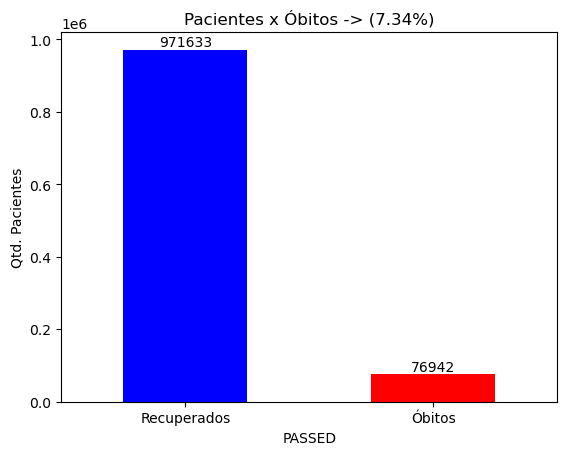

In [13]:
plot_percentual_deads(covid_df)

### Relação idade x covid

In [14]:
def create_df_age_interval(df):
    age_bins = pd.cut(df['AGE'], bins=13, precision=0)
    df_passed_age = pd.DataFrame(columns=["Intervalo Idade", "PASSED"], data={"Intervalo Idade": age_bins, "PASSED": df.PASSED})

    return df_passed_age.groupby(['Intervalo Idade', 'PASSED']).size().unstack()

df_grouped = create_df_age_interval(covid_df)

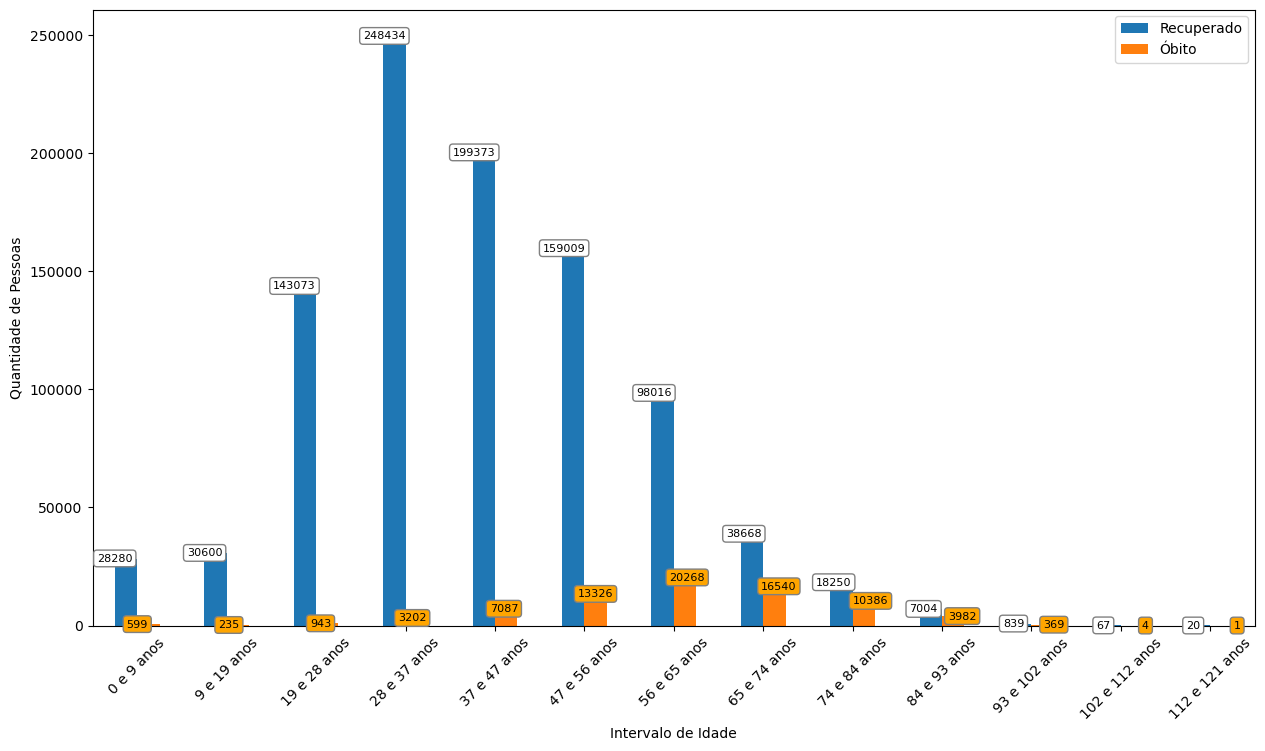

In [15]:
def calculate_quantity_passed_by_age(df_grouped):
    # Definindo os rótulos personalizados para cada intervalo de idade
    rotulos = ['{} e {} anos'.format(int(i.left), int(i.right)) for i in df_grouped.index]


    # Plotando o gráfico de barras com os rótulos personalizados no eixo x
    ax = df_grouped.plot(kind='bar', figsize=(15, 8))
    plt.xlabel('Intervalo de Idade')
    plt.ylabel('Quantidade de Pessoas')

    # Definindo os rótulos personalizados no eixo x
    plt.xticks(range(len(rotulos)), rotulos, rotation=45)
    plt.legend(["Recuperado", "Óbito"])

    # Estilo e cores da caixa
    bbox_props = dict(boxstyle="round", fc="white", ec="gray", lw=1)

    for i,p in enumerate(ax.patches):
        x = p.get_x() * 1.005
        y = p.get_height() * 1.005

        if(i>=13):
            bbox_props["fc"] = 'orange'
            x = p.get_x() * 1.025


        ax.text(x, y, str(p.get_height()), ha='center', va='center', fontsize=8, bbox=bbox_props, )

    plt.show()

calculate_quantity_passed_by_age(df_grouped)

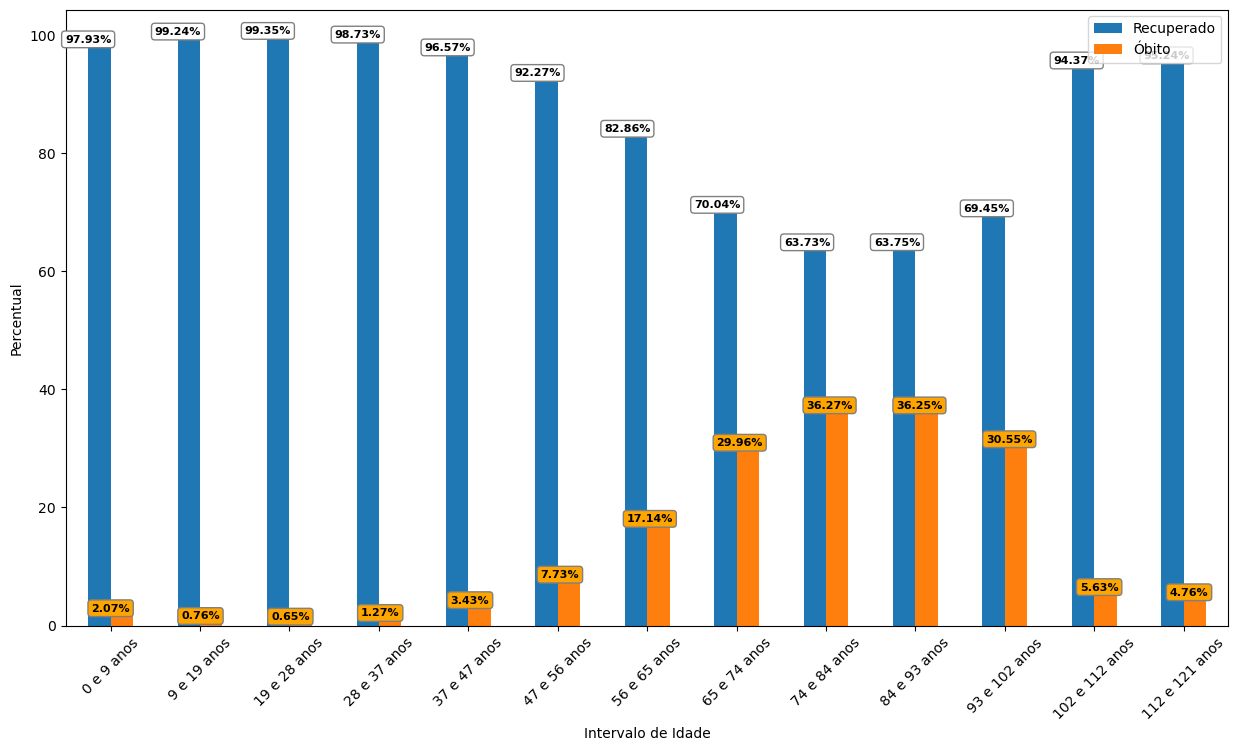

In [16]:
def calculate_percentual_passed_by_age_interval(df_grouped):
    # Rotulos (0 a 9 anos, 9 a 19 anos, etc)
    rotulos = ['{} e {} anos'.format(int(i.left), int(i.right)) for i in df_grouped.index]

    # Calcula percentual de recuperados
    df_grouped['% Recuperados'] = (df_grouped[0]*100)/(df_grouped[0] + df_grouped[1])
    df_grouped['% Óbitos'] = 100 - df_grouped['% Recuperados']
    df_grouped_percentual = df_grouped.drop(columns=[0, 1])

    # Tipo de gráfico e suas propriedades
    ax = df_grouped_percentual.plot(kind='bar', figsize=(15, 8))
    plt.xlabel('Intervalo de Idade')
    plt.ylabel('Percentual')

    # Definindo os rótulos personalizados no eixo x
    plt.xticks(range(len(rotulos)), rotulos, rotation=45)
    plt.legend(['Recuperado','Óbito'])

    # Estilo e cores da caixa
    bbox_props = dict(boxstyle="round", fc="white", ec="gray", lw=1)

    for i, p in enumerate(ax.patches):
        # Posição da caixa
        x = p.get_x() * 1.005
        y = p.get_height() * 1.005

        # Colore de laranja apenas óbitos
        if(i>=13):
            bbox_props["fc"] = 'orange'
        ax.annotate("{:.2f}%".format(p.get_height()), (x, y), ha='center', va='bottom', fontsize=8, weight='bold', bbox=bbox_props)


calculate_percentual_passed_by_age_interval(df_grouped)

## Relação de doenças

In [17]:
covid_df.ASTHMA.value_counts()

ASTHMA
2     1014024
1       31572
98       2979
Name: count, dtype: int64

In [18]:
def calculate_comorbidities(df):
    # Colunas de comorbidades
    comorbidities = ['PNEUMONIA', 'HIPERTENSION', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
                     'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'CARDIOVASCULAR']

    # Valor na base para 1 (true) e 2 (false)
    TRUE_VALUE = 1
    FALSE_VALUE = 2

    # Cria df
    df_comorbidity = pd.DataFrame(columns=['Falecidos', 'Total', 'Falecidos %'], index=comorbidities )
    df_comorbidity.rename_axis("Comorbidades", inplace=True)

    for comorbidity in comorbidities:
        # Quantidade  pela comorbidade
        filter_comorbidity_death = (df[comorbidity] == TRUE_VALUE) & (df['PASSED'] == 1)
        qtd_comorbidity_dead = df[filter_comorbidity_death].shape[0]

        # Quantidade totais (apenas que morreu)
        filter_total = ((df[comorbidity] == TRUE_VALUE) | (df[comorbidity] == FALSE_VALUE)) & (df['PASSED'] == 1)
        qtd_total = len(df[filter_total])

        # Quantidade sobreviventes
        qtd_survival = qtd_total - qtd_comorbidity_dead
        percentual = (qtd_comorbidity_dead/qtd_total) * 100

        # Adicona valores ao df
        df_comorbidity.loc[comorbidity]['Falecidos'] = qtd_comorbidity_dead
        df_comorbidity.loc[comorbidity]['Total'] = qtd_total
        df_comorbidity.loc[comorbidity]['Falecidos %'] = percentual



    return df_comorbidity.sort_values(by="Falecidos %", ascending=False)

calculate_comorbidities(covid_df)

Falecidos  Total Falecidos %
Comorbidades                               
PNEUMONIA          53923  76208   70.757663
HIPERTENSION       32061  76252    42.04611
DIABETES           28265  76211   37.087822
OBESITY            17294  76227   22.687499
TOBACCO             6596  76217    8.654237
RENAL_CHRONIC       5707  76239     7.48567
CARDIOVASCULAR      4435  76209    5.819523
COPD                4021  76231    5.274757
INMSUPR             2618  76187    3.436282
ASTHMA              1480  76238    1.941289

## Relação INTUBED e ICU

### Coorelação entre "INTUBED" e "PATIENT_TYPE"

In [19]:
covid_df[["INTUBED","PATIENT_TYPE"]].corr()

INTUBED  PATIENT_TYPE
INTUBED       1.000000     -0.976335
PATIENT_TYPE -0.976335      1.000000

### Verificando as relações de INTUBED
* [1] foi para casa e [2] hospitalizado (*1 for returned home and 2 for hospitalization.*)

In [20]:
covid_df["INTUBED"].value_counts()

INTUBED
97    848544
2     159050
1      33656
99      7325
Name: count, dtype: int64

#### Quantidade de pacientes que foram intubados e foram hospitalizados

In [21]:
covid_df[(covid_df["INTUBED"] == 1) & (covid_df["PATIENT_TYPE"] == 2)].shape

(33656, 21)

#### Quantidade de pacientes que NÃO foram intubados e foram para casa

In [22]:
covid_df[(covid_df["INTUBED"] == 2) & (covid_df["PATIENT_TYPE"] == 1)].shape

(0, 21)

#### Verificando quantos pacientes possuem  INTUBED nulo e foram marcados como [1] para casa

In [23]:
covid_df[(covid_df["INTUBED"] >= 97) & (covid_df["PATIENT_TYPE"] == 1)].shape

(848544, 21)

Resumo das informações acima:
* Todos pacientes intubados foram hospitalizados.
* Não há registros para pacientes não intubados que foram para casa.
* Todos pacientes marcados com INTUBED nulo (97), foram para casa.
* Todos pacientes com INTUBED nulo (99), foram hospitalizados.

### Verificando as relações de ICU

In [24]:
covid_df["ICU"].value_counts()

ICU
97    848544
2     175685
1      16858
99      7488
Name: count, dtype: int64

#### Quantidade de pacientes que foram para ICU e foram hospitalizados

In [25]:
covid_df[(covid_df["ICU"] == 1) & (covid_df["PATIENT_TYPE"] == 2)].shape

(16858, 21)

#### Quantidade de pacientes que NÃO foram para ICU, e foram para casa

In [26]:
covid_df[(covid_df["ICU"] == 2) & (covid_df["PATIENT_TYPE"] == 1)].shape

(0, 21)

#### Verificando quantos pacientes possuem ICU nulo e foram marcados como [1] para casa

In [27]:
covid_df[(covid_df["ICU"] >= 97) & (covid_df["PATIENT_TYPE"] == 1)].shape

(848544, 21)

#### Verificando quantos pacientes possuem ICU nulo e foram marcados como [2] hospitalizados

In [28]:
covid_df[(covid_df["ICU"] >= 97) & (covid_df["PATIENT_TYPE"] == 2)].shape

(7488, 21)

Resumo das informações acima:
* Todos pacientes de UTI (ICU) foram hospitalizados.
* Não há registros para pacientes não ICU, que foram para casa.
* Todos pacientes marcados com ICU nulo (97), foram para casa.
* Todos pacientes com ICU nulo (99), foram hospitalizados.

# Tratando Dados

In [29]:
covid_df.shape

(1048575, 21)

### Coluna PREGNANT

In [30]:
covid_df['PREGNANT'].value_counts()

PREGNANT
97    523511
2     513179
1       8131
98      3754
Name: count, dtype: int64

In [31]:
#Altera os valores para Homens, para sem gravidez
covid_df['PREGNANT'] = covid_df['PREGNANT'].replace(97, 2)

#Remove linhas com valores ausentes
covid_df = covid_df.drop(covid_df[covid_df.PREGNANT == 98].index)
covid_df = covid_df[(covid_df.PREGNANT == 1) | (covid_df.PREGNANT == 2)]

In [32]:
#Resultado apos tratamento
# Como há poucas linhas com mulheres grávidas,
# essa coluna se torna uma constante, com isso, não necessita deste atributo
# e será removido mais a frente.
covid_df.PREGNANT.value_counts(dropna=False)

PREGNANT
2    1036690
1       8131
Name: count, dtype: int64

### Coluna INTUBED
Para casos em que INTUBED é nulo e o paciente hospitalizado, receberá o valor NaN. De outra forma, recebe 2 [Não], quando o paciente foi para casa.

In [33]:
# Paciente [2] hospitalizado
filter_intubed_1 = (covid_df["INTUBED"] >= 97) & (covid_df["PATIENT_TYPE"] == 2)
covid_df.loc[filter_intubed_1, "INTUBED"] = np.nan
covid_df["INTUBED"].value_counts()

INTUBED
97.0    845277
2.0     158768
1.0      33609
Name: count, dtype: int64

In [34]:
# Paciente [1] para casa
filter_intubed_2 = (covid_df["INTUBED"] >= 97) & (covid_df["PATIENT_TYPE"] == 1)
covid_df.loc[filter_intubed_2, "INTUBED"] = 2
covid_df["INTUBED"].value_counts()

INTUBED
2.0    1004045
1.0      33609
Name: count, dtype: int64

### Coluna ICU
Se ICU nulo e foi hospitalizado, então recebe NaN. Se não, recebe 2 [Não].

In [35]:
# Paciente [2] hospitalizado
filter_icu_1 = (covid_df["ICU"] >= 97) & (covid_df["PATIENT_TYPE"] == 2)
covid_df.loc[filter_icu_1, "ICU"] = np.nan
covid_df["ICU"].value_counts()

ICU
97.0    845277
2.0     175386
1.0      16830
Name: count, dtype: int64

In [36]:
# Paciente [1] para casa
filter_icu_2 = (covid_df["ICU"] >= 97) & (covid_df["PATIENT_TYPE"] == 1)
covid_df.loc[filter_icu_2, "ICU"] = 2
covid_df["ICU"].value_counts()

ICU
2.0    1020663
1.0      16830
Name: count, dtype: int64

In [37]:
covid_df.isna().sum()

USMER                      0
MEDICAL_UNIT               0
SEX                        0
PATIENT_TYPE               0
INTUBED                 7167
PNEUMONIA                  0
AGE                        0
PREGNANT                   0
DIABETES                   0
COPD                       0
ASTHMA                     0
INMSUPR                    0
HIPERTENSION               0
OTHER_DISEASE              0
CARDIOVASCULAR             0
OBESITY                    0
RENAL_CHRONIC              0
TOBACCO                    0
CLASIFFICATION_FINAL       0
ICU                     7328
PASSED                     0
dtype: int64

### Colunas NaN

In [38]:
def verify_num_cols(df):
    # Média ordenada e colunas com valor vazio
    mean_na = df.isna().mean().sort_values(ascending=False)

    # Cria DF de colunas nulas
    df_na = pd.DataFrame({"percentual": mean_na})

    return df_na

def remove_nan_cols_above_limit(df, cols_to_ignore, limit=0.30):
    # Obtém colunas nulas e seu percentual
    df_na = verify_num_cols(df)

    # Ignora colunas
    df_na.drop(cols_to_ignore, inplace=True)

    # Filtra colunas pelo limite
    df_na_above_limit = df_na[df_na.percentual >= limit]

    # Obtém as colunas a serem dropadas
    columns_to_drop = df_na_above_limit.index

    # Dropa colunas
    df.drop(columns=columns_to_drop, inplace=True)

    return df, df_na_above_limit

In [39]:
# Remove colunas nulas acima do limite de 5%
# Coluna considera importante para ser removida
cols_to_ignore = ["ICU", "INTUBED"]
_, df_na = remove_nan_cols_above_limit(covid_df, cols_to_ignore, limit=0.05)

# Colunas removidas
df_na

Empty DataFrame
Columns: [percentual]
Index: []

In [40]:
covid_df.shape

(1044821, 21)

In [41]:
covid_df.isna().sum()

USMER                      0
MEDICAL_UNIT               0
SEX                        0
PATIENT_TYPE               0
INTUBED                 7167
PNEUMONIA                  0
AGE                        0
PREGNANT                   0
DIABETES                   0
COPD                       0
ASTHMA                     0
INMSUPR                    0
HIPERTENSION               0
OTHER_DISEASE              0
CARDIOVASCULAR             0
OBESITY                    0
RENAL_CHRONIC              0
TOBACCO                    0
CLASIFFICATION_FINAL       0
ICU                     7328
PASSED                     0
dtype: int64

### Removendo colunas desnecessárias

* PREGNANT - Coluna constante

In [42]:
# Removendo colunas
covid_df.drop(columns=["PREGNANT"], inplace=True)

In [43]:
# Remove linhas com alguma coluna nula
covid_df.dropna(inplace=True)

### Removendo campos nulos
Obtendo apenas os valores válidos

*OBS: AGE pode conter valores maior que 96

In [44]:
# Nessa base valores como 97, 98 e 99 são nulos
def check_columns():
  for i in covid_df.columns:
    temp_df = covid_df[(covid_df[i] == 99) | (covid_df[i] == 97) | (covid_df[i] == 98)]
    print(i + " : ",temp_df[i].count())

check_columns()

USMER :  0
MEDICAL_UNIT :  0
SEX :  0
PATIENT_TYPE :  0
INTUBED :  0
PNEUMONIA :  10652
AGE :  327
DIABETES :  3133
COPD :  2797
ASTHMA :  2770
INMSUPR :  3159
HIPERTENSION :  2906
OTHER_DISEASE :  4759
CARDIOVASCULAR :  2865
OBESITY :  2838
RENAL_CHRONIC :  2804
TOBACCO :  3018
CLASIFFICATION_FINAL :  0
ICU :  0
PASSED :  0


In [45]:
# Filtra por valores no intervalo permitido
columns_filter = ['PNEUMONIA', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO']
for c in columns_filter:
    covid_df = covid_df[(covid_df[c] == 1) | (covid_df[c] == 2)]

check_columns()

USMER :  0
MEDICAL_UNIT :  0
SEX :  0
PATIENT_TYPE :  0
INTUBED :  0
PNEUMONIA :  0
AGE :  321
DIABETES :  0
COPD :  0
ASTHMA :  0
INMSUPR :  0
HIPERTENSION :  0
OTHER_DISEASE :  0
CARDIOVASCULAR :  0
OBESITY :  0
RENAL_CHRONIC :  0
TOBACCO :  0
CLASIFFICATION_FINAL :  0
ICU :  0
PASSED :  0


In [46]:
covid_df.PASSED.value_counts()

PASSED
0    946356
1     73310
Name: count, dtype: int64

In [47]:
for i in covid_df.columns:
    print(i,"----->",len(covid_df[i].unique()))

USMER -----> 2
MEDICAL_UNIT -----> 13
SEX -----> 2
PATIENT_TYPE -----> 2
INTUBED -----> 2
PNEUMONIA -----> 2
AGE -----> 121
DIABETES -----> 2
COPD -----> 2
ASTHMA -----> 2
INMSUPR -----> 2
HIPERTENSION -----> 2
OTHER_DISEASE -----> 2
CARDIOVASCULAR -----> 2
OBESITY -----> 2
RENAL_CHRONIC -----> 2
TOBACCO -----> 2
CLASIFFICATION_FINAL -----> 7
ICU -----> 2
PASSED -----> 2


# Encoding

## Label Encoding

In [48]:
label_encoder = LabelEncoder()

In [49]:
covid_df["CLASIFFICATION_FINAL"] = label_encoder.fit_transform(covid_df["CLASIFFICATION_FINAL"])
covid_df["USMER"] = label_encoder.fit_transform(covid_df["USMER"])

## One-hot Encoding

In [50]:
# Define colunas a serem ignoradas
ignore_columns = ["CLASIFFICATION_FINAL", "AGE", "PASSED", "USMER"]
onehot_encoder_cols = [col for col in covid_df.columns.tolist() if col not in ignore_columns]

# Instancia o OneHotEnconder
one_hot_encoder = OneHotEncoder(sparse_output=False)

In [51]:
# Realiza o fit-transform
one_hot_result = one_hot_encoder.fit_transform(covid_df[onehot_encoder_cols])

# Obtem os nomes das colunas
one_hot_col_result = one_hot_encoder.get_feature_names_out(onehot_encoder_cols)

# Armazena em um novo DF
one_hot_col_df = pd.DataFrame(one_hot_result, columns=one_hot_col_result, index=covid_df.index)
one_hot_col_df.shape

(1019666, 43)

In [52]:
one_hot_col_result

array(['MEDICAL_UNIT_1', 'MEDICAL_UNIT_2', 'MEDICAL_UNIT_3',
       'MEDICAL_UNIT_4', 'MEDICAL_UNIT_5', 'MEDICAL_UNIT_6',
       'MEDICAL_UNIT_7', 'MEDICAL_UNIT_8', 'MEDICAL_UNIT_9',
       'MEDICAL_UNIT_10', 'MEDICAL_UNIT_11', 'MEDICAL_UNIT_12',
       'MEDICAL_UNIT_13', 'SEX_1', 'SEX_2', 'PATIENT_TYPE_1',
       'PATIENT_TYPE_2', 'INTUBED_1.0', 'INTUBED_2.0', 'PNEUMONIA_1',
       'PNEUMONIA_2', 'DIABETES_1', 'DIABETES_2', 'COPD_1', 'COPD_2',
       'ASTHMA_1', 'ASTHMA_2', 'INMSUPR_1', 'INMSUPR_2', 'HIPERTENSION_1',
       'HIPERTENSION_2', 'OTHER_DISEASE_1', 'OTHER_DISEASE_2',
       'CARDIOVASCULAR_1', 'CARDIOVASCULAR_2', 'OBESITY_1', 'OBESITY_2',
       'RENAL_CHRONIC_1', 'RENAL_CHRONIC_2', 'TOBACCO_1', 'TOBACCO_2',
       'ICU_1.0', 'ICU_2.0'], dtype=object)

In [53]:
# Dropa colunas antigas e adiciona as novas
covid_df = covid_df.drop(columns=onehot_encoder_cols).join(one_hot_col_df)
covid_df.shape

(1019666, 47)

In [54]:
# Liberar Memoria
del one_hot_col_df
del one_hot_result

In [55]:
covid_df.head()

USMER  AGE  CLASIFFICATION_FINAL  PASSED  MEDICAL_UNIT_1  MEDICAL_UNIT_2  \
0      1   65                     2       1             1.0             0.0   
1      1   72                     4       1             1.0             0.0   
2      1   55                     2       1             1.0             0.0   
3      1   53                     6       1             1.0             0.0   
4      1   68                     2       1             1.0             0.0   

   MEDICAL_UNIT_3  MEDICAL_UNIT_4  MEDICAL_UNIT_5  MEDICAL_UNIT_6  ...  \
0             0.0             0.0             0.0             0.0  ...   
1             0.0             0.0             0.0             0.0  ...   
2             0.0             0.0             0.0             0.0  ...   
3             0.0             0.0             0.0             0.0  ...   
4             0.0             0.0             0.0             0.0  ...   

   CARDIOVASCULAR_1  CARDIOVASCULAR_2  OBESITY_1  OBESITY_2  RENAL_CHRONIC_1  \
0               0.0               1.0        0.0        1.0              0.0   
1               0.0               1.0        1.0        0.0              1.0   
2               0.0               1.0        0.0        1.0              0.0   
3               0.0               1.0        0.0        1.0              0.0   
4               0.0               1.0        0.0        1.0              0.0   

   RENAL_CHRONIC_2  TOBACCO_1  TOBACCO_2  ICU_1.0  ICU_2.0  
0              1.0        0.0        1.0      0.0      1.0  
1              0.0        0.0        1.0      0.0      1.0  
2              1.0        0.0        1.0      0.0      1.0  
3              1.0        0.0        1.0      0.0      1.0  
4              1.0        0.0        1.0      0.0      1.0  

[5 rows x 47 columns]

# Definindo Target e Features

In [56]:
covid_df.shape

(1019666, 47)

In [57]:
y = covid_df.PASSED
y

0          1
1          1
2          1
3          1
4          1
          ..
1048570    0
1048571    0
1048572    0
1048573    0
1048574    0
Name: PASSED, Length: 1019666, dtype: int64

In [58]:
X = covid_df.drop(columns=["PASSED"], axis=1).to_numpy()
X

array([[ 1., 65.,  2., ...,  1.,  0.,  1.],
       [ 1., 72.,  4., ...,  1.,  0.,  1.],
       [ 1., 55.,  2., ...,  1.,  0.,  1.],
       ...,
       [ 1., 55.,  6., ...,  1.,  0.,  1.],
       [ 1., 28.,  6., ...,  1.,  0.,  1.],
       [ 1., 52.,  6., ...,  1.,  0.,  1.]])

# Balanceando dados (Demonstração) - Undersampling
* O gráfico em barras abaixo, demostra como estão desbalanceado os dados deste dataset

In [59]:
# Balanceia pela classe majoritária
rus = RandomUnderSampler(sampling_strategy='majority')
X, y = rus.fit_resample(X, y)

PASSED
0    946356
1     73310
Name: count, dtype: int64


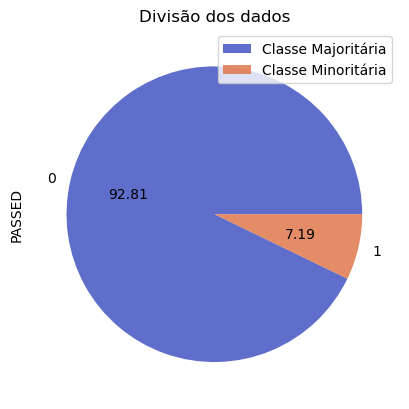

In [60]:
# Antes
covid_df["PASSED"].value_counts().plot.pie(autopct='%.2f', colors = ['#374ABDCC', '#DE6F40CC'], ylabel="PASSED")
plt.title("Divisão dos dados")
plt.legend(["Classe Majoritária", "Classe Minoritária"], loc="upper right")
print(covid_df["PASSED"].value_counts())

Percentural of deads 7.19]



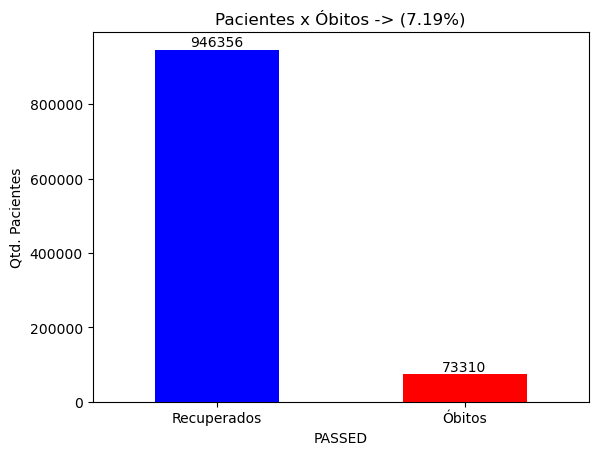

In [61]:
# Antes
plot_percentual_deads(covid_df)

<Axes: xlabel='PASSED'>

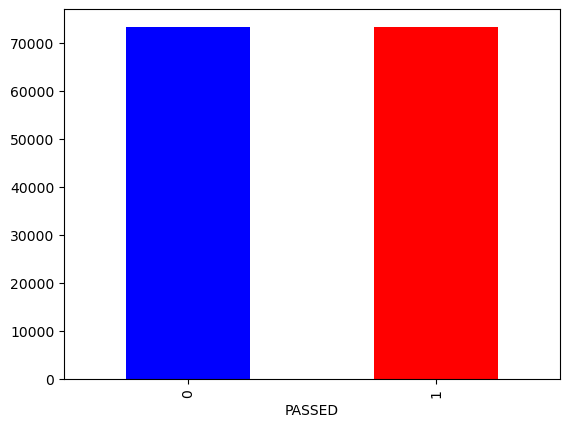

In [62]:
y.value_counts().plot(kind="bar", color = ["blue", "red"])

In [63]:
y.value_counts()

PASSED
0    73310
1    73310
Name: count, dtype: int64

# Funções compartilhadas

In [64]:
def computes_metrics(clf, X_train, y_train, X_test, y_test, metrics):
    # Treina o modelo
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Calcula as métricas
    accuracy  = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall    = recall_score(y_test, y_pred)
    f1        = f1_score(y_test, y_pred)
    roc_auc   = roc_auc_score(y_test, y_pred)

    return accuracy, precision, recall, f1, roc_auc


def save_metrics(clf_name, metrics, resultado, index, df_results):
    # Salva as métricas em um DF de resultados
    for i,metrica in enumerate(metrics):
        df_results.loc[clf_name, metrica][index] = resultado[i]

def boxplot_sorted(df, score, rot=90, figsize=(8,5), fontsize=20):
    # Plota boxplot dos modelos
    df2 = df.xs(score, level=1, drop_level=True).T
    meds = df2.median().sort_values(ascending=False)
    axes = df2[meds.index].boxplot(
                    figsize=figsize, rot=rot, fontsize=fontsize,
                    boxprops=dict(linewidth=4, color='cornflowerblue'),
                    whiskerprops=dict(linewidth=4, color='cornflowerblue'),
                    medianprops=dict(linewidth=4, color='firebrick'),
                    capprops=dict(linewidth=4, color='cornflowerblue'),
                    flierprops=dict(marker='o', markerfacecolor='dimgray',
                                    markersize=12, markeredgecolor='black'),
                    return_type="axes")

    axes.set_title(f'Boxplots of {score} metric',
                   fontsize=fontsize)
    plt.show()

# Ajuste de hiperparâmetros

## Preparando dados

* Nesse caso, é necessário reduzir de forma estratificada os dados, já que essa base
possui aproximadamente 73 mil óbitos (classe minoritária). Ou seja,
aplicar o RUS faria com que a base tivesse cerca de 73 mil óbitos e 73 mil sobreviventes
o que gera mais de 140 mil dados para serem passados pela etapa de ajuste de hiperparâmetros,
fazendo com que seja lento a busca pelos hiperparâmetros.
* Com isso, reduzimos os dados em 20% (200 mil linhas). Aplicando o RUS cada classe é representada por
aproximadamente 14 mil dados (total de 28 mil).

In [65]:
def prepare_data_hiper_params(df, class_target):
    # Realiza RUS na classe majoritária
    rus = RandomUnderSampler(sampling_strategy="majority")
    X_rus, y_rus = rus.fit_resample(df.drop(columns=[class_target]), df[class_target])

    return X_rus, y_rus

## Funções Auxiliares

In [66]:
# Classe que envolve o nome, modelo e seus parâmetros
class ModelWrapper():
    def __init__(self, name, params_grid={}):
        self.name = name
        self.params_grid = params_grid
        self.best_params = {}
        self.model = None

    def get_name(self):
        return self.name

    def get_model(self):
        if(self.model is None):
            return self.init_model()
        return self.model

    def get_params_grid(self):
        return self.params_grid

    def get_best_params(self):
        return self.best_params

    def set_best_params(self, best_params):
        self.best_params = best_params

    def factory_model(self):
        if(self.name == "LR"):
            return LogisticRegression(**self.best_params)

        elif(self.name == "RF"):
            return RandomForestClassifier(**self.best_params)

        elif(self.name == "XGBoost"):
            return XGBClassifier(**self.best_params)

        elif(self.name == "CatBoost"):
            return CatBoostClassifier(**self.best_params)

        else:
            raise ValueError(f"The estimator {self.name} is not implemented.")

    def init_model(self):
        # Força liberar memoria de self.model
        if(self.model is not None):
            del self.model
            self.model = None
        self.model = self.factory_model()
        return self.model

In [67]:
def init_clfs():
    return [
        ModelWrapper('LR',  {
            'max_iter': [2000, 2300, 2500, 3000],
            'class_weight': ['balanced', None],
            'solver': ['lbfgs', 'liblinear']}),

        ModelWrapper('RF', {
            'n_estimators': [100, 400, 1000, 2000],
            'max_depth': [1, 3, 6, 8],
        }),

        ModelWrapper('XGBoost', {
            'n_estimators': [100, 400, 1000, 2000],
            'max_depth': [1, 3, 6, 8],
        }),

        ModelWrapper('CatBoost', {
            'n_estimators': [100, 400, 1000, 2000],
            'max_depth': [1, 3, 6, 8],
        })
    ]

def save_results_in_file(df_results):
    date_time = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f'./results/mx_tb_results_{date_time}'
    
    df_results.to_csv(filename)

## Execução

In [68]:
# Instancia classificadores e busca seus melhores parâmetros
def tuning_hyperparameters(df, target, balanced=True, stratified=False):
    if stratified:
        # Agrupa por PASSED e aplica o SAMPLE em cada grupo
        df = df.groupby(target, group_keys=False).apply(lambda g: g.sample(frac=0.2))
    
     # Define características e variável alvo
    X_train = df.drop(columns=[target])
    y_train = df[target]
    
    # Inicia os modelos
    clfs = init_clfs()
    best_clfs = {}

    if balanced:
        # Dados com RUS
        X_train, y_train = prepare_data_hiper_params(df, target)

    # Itera classificadores
    for clf in clfs:
        # Executa hiper-parâmetros no classificador
        grid = GridSearchCV(estimator = clf.get_model(), param_grid = clf.get_params_grid(), cv = 5)
        grid.fit(X_train, y_train)

        # Armazena melhores parâmetros
        best_clfs[clf.get_name()] = grid.best_params_
        clf.set_best_params(grid.best_params_)

    return clfs, pd.DataFrame(best_clfs)

best_clfs, df_bests_clfs = tuning_hyperparameters(covid_df, "PASSED", stratified=True)
df_bests_clfs

Learning rate set to 0.327383
0:	learn: 0.4780166	total: 147ms	remaining: 14.6s
1:	learn: 0.3950489	total: 152ms	remaining: 7.45s
2:	learn: 0.3523045	total: 157ms	remaining: 5.07s
3:	learn: 0.3265932	total: 162ms	remaining: 3.88s
4:	learn: 0.3064635	total: 166ms	remaining: 3.16s
5:	learn: 0.2932234	total: 171ms	remaining: 2.68s
6:	learn: 0.2840162	total: 175ms	remaining: 2.33s
7:	learn: 0.2758079	total: 180ms	remaining: 2.07s
8:	learn: 0.2688156	total: 185ms	remaining: 1.87s
9:	learn: 0.2644140	total: 189ms	remaining: 1.7s
10:	learn: 0.2610728	total: 193ms	remaining: 1.56s
11:	learn: 0.2574337	total: 198ms	remaining: 1.45s
12:	learn: 0.2546828	total: 202ms	remaining: 1.35s
13:	learn: 0.2524845	total: 206ms	remaining: 1.27s
14:	learn: 0.2511779	total: 211ms	remaining: 1.2s
15:	learn: 0.2490835	total: 216ms	remaining: 1.13s
16:	learn: 0.2454283	total: 220ms	remaining: 1.07s
17:	learn: 0.2440601	total: 225ms	remaining: 1.02s
18:	learn: 0.2427889	total: 229ms	remaining: 978ms
19:	learn: 0.

LR     RF  XGBoost  CatBoost
class_weight  balanced    NaN      NaN       NaN
max_iter          2000    NaN      NaN       NaN
solver           lbfgs    NaN      NaN       NaN
max_depth          NaN    8.0      3.0       3.0
n_estimators       NaN  100.0    100.0     400.0

# Validação cruzada

## Execução

In [69]:
def execute_models(df, target, best_clfs, balanced=True):
    # Settings
    TEST_SIZE = 0.3
    TRAIN_SIZE = 0.7
    n_rodadas = 30

    Clfs_names = [ 'LR', 'RF', 'XGBoost', 'CatBoost']
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    m_index = pd.MultiIndex.from_product([Clfs_names, metrics])

    # Atributos e Alvo
    X = df.drop(columns=[target])
    y = df[target]
        
    df_results = pd.DataFrame(data=np.zeros((len(m_index), n_rodadas)), index=m_index)

    for col in range(n_rodadas):

        if balanced:
            # RandomUnderSampler
            rus = RandomUnderSampler(sampling_strategy='majority')
            X, y = rus.fit_resample(X, y)
        
        # Hold out
        X_train, X_test,\
        y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y)
        
        for best_clf in best_clfs:
            # Reseta/Inicia modelo com seus melhores parâmetros
            clf_model = best_clf.init_model()
           
            #Treina o modelo utilizando o conjunto de teste
            metrics_results = computes_metrics(clf_model, X_train, y_train, X_test, y_test, metrics)
            save_metrics(best_clf.get_name(), metrics, metrics_results, col, df_results)
            
    return df_results

In [70]:
df_results = execute_models(covid_df, "PASSED", best_clfs)
save_results_in_file(df_results)
df_results

Learning rate set to 0.172451
0:	learn: 0.5182388	total: 8.89ms	remaining: 3.55s
1:	learn: 0.4232399	total: 16ms	remaining: 3.18s
2:	learn: 0.3622688	total: 23.9ms	remaining: 3.16s
3:	learn: 0.3226184	total: 31ms	remaining: 3.07s
4:	learn: 0.2968694	total: 38.2ms	remaining: 3.02s
5:	learn: 0.2786740	total: 45.9ms	remaining: 3.02s
6:	learn: 0.2690189	total: 53ms	remaining: 2.98s
7:	learn: 0.2601129	total: 60ms	remaining: 2.94s
8:	learn: 0.2541013	total: 66.9ms	remaining: 2.9s
9:	learn: 0.2491535	total: 73.5ms	remaining: 2.87s
10:	learn: 0.2461279	total: 80.2ms	remaining: 2.84s
11:	learn: 0.2436022	total: 87.4ms	remaining: 2.83s
12:	learn: 0.2414061	total: 93.7ms	remaining: 2.79s
13:	learn: 0.2395471	total: 100ms	remaining: 2.76s
14:	learn: 0.2375285	total: 107ms	remaining: 2.75s
15:	learn: 0.2356036	total: 114ms	remaining: 2.73s
16:	learn: 0.2340324	total: 121ms	remaining: 2.72s
17:	learn: 0.2327985	total: 128ms	remaining: 2.71s
18:	learn: 0.2314179	total: 134ms	remaining: 2.69s
19:	lea

0         1         2         3         4   \
LR       accuracy   0.908175  0.910381  0.909221  0.908107  0.911767   
         precision  0.899760  0.900262  0.900748  0.900710  0.904033   
         recall     0.918701  0.923021  0.919793  0.917337  0.921339   
         f1         0.909132  0.911499  0.910171  0.908948  0.912604   
         roc_auc    0.908175  0.910381  0.909221  0.908107  0.911767   
RF       accuracy   0.909358  0.911404  0.912699  0.912063  0.914132   
         precision  0.878373  0.881129  0.884028  0.881852  0.885116   
         recall     0.950302  0.951121  0.950030  0.951621  0.951803   
         f1         0.912923  0.914788  0.915841  0.915409  0.917249   
         roc_auc    0.909358  0.911404  0.912699  0.912063  0.914132   
XGBoost  accuracy   0.917224  0.918679  0.918815  0.917155  0.920816   
         precision  0.892808  0.892799  0.894205  0.892929  0.897859   
         recall     0.948302  0.951621  0.950030  0.947983  0.949666   
         f1         0.919719  0.921272  0.921273  0.919633  0.923036   
         roc_auc    0.917224  0.918679  0.918815  0.917155  0.920816   
CatBoost accuracy   0.917246  0.918679  0.919111  0.918565  0.921475   
         precision  0.891974  0.892364  0.894534  0.893683  0.898089   
         recall     0.949484  0.952212  0.950257  0.950166  0.950848   
         f1         0.919831  0.921317  0.921554  0.921060  0.923716   
         roc_auc    0.917246  0.918679  0.919111  0.918565  0.921475   

                          5         6         7         8         9   ...  \
LR       accuracy   0.910335  0.906789  0.910676  0.909789  0.909039  ...   
         precision  0.903149  0.897463  0.904696  0.902182  0.902686  ...   
         recall     0.919247  0.918520  0.918065  0.919247  0.916928  ...   
         f1         0.911127  0.907869  0.911331  0.910635  0.909751  ...   
         roc_auc    0.910335  0.906789  0.910676  0.909789  0.909039  ...   
RF       accuracy   0.913131  0.910199  0.913859  0.912427  0.913882  ...   
         precision  0.885359  0.880125  0.884570  0.882318  0.886403  ...   
         recall     0.949166  0.949757  0.951939  0.951803  0.949438  ...   
         f1         0.916153  0.913616  0.917019  0.915744  0.916839  ...   
         roc_auc    0.913131  0.910199  0.913859  0.912427  0.913882  ...   
XGBoost  accuracy   0.918679  0.916473  0.920543  0.918701  0.919906  ...   
         precision  0.895091  0.891448  0.897123  0.894048  0.897444  ...   
         recall     0.948529  0.948438  0.950030  0.949984  0.948165  ...   
         f1         0.921036  0.919061  0.922819  0.921167  0.922107  ...   
         roc_auc    0.918679  0.916473  0.920543  0.918701  0.919906  ...   
CatBoost accuracy   0.919315  0.916814  0.920520  0.919611  0.919997  ...   
         precision  0.895082  0.891217  0.897597  0.894937  0.896847  ...   
         recall     0.949984  0.949529  0.949348  0.950848  0.949166  ...   
         f1         0.921716  0.919450  0.922747  0.922046  0.922265  ...   
         roc_auc    0.919315  0.916814  0.920520  0.919611  0.919997  ...   

                          20        21        22        23        24  \
LR       accuracy   0.909039  0.909562  0.908425  0.909335  0.910744   
         precision  0.900570  0.902498  0.900951  0.900414  0.902616   
         recall     0.919611  0.918338  0.917747  0.920475  0.920838   
         f1         0.909991  0.910349  0.909271  0.910334  0.911636   
         roc_auc    0.909039  0.909562  0.908425  0.909335  0.910744   
RF       accuracy   0.911426  0.912563  0.909448  0.912699  0.912927   
         precision  0.880877  0.884129  0.879158  0.883250  0.882911   
         recall     0.951530  0.949575  0.949393  0.951121  0.952121   
         f1         0.914842  0.915684  0.912927  0.915930  0.916211   
         roc_auc    0.911426  0.912563  0.909448  0.912699  0.912927   
XGBoost  accuracy   0.917860  0.918610  0.918451  0.918770  0.919020   
         precision  0.893643  0

## Resultado

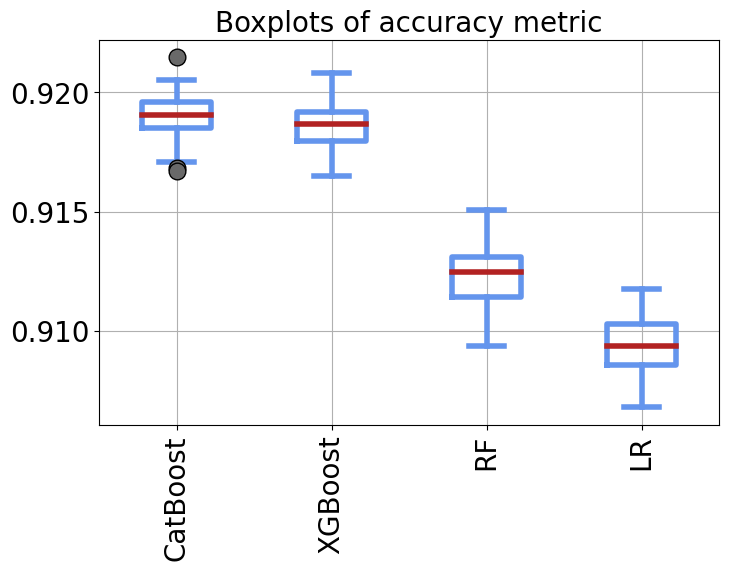

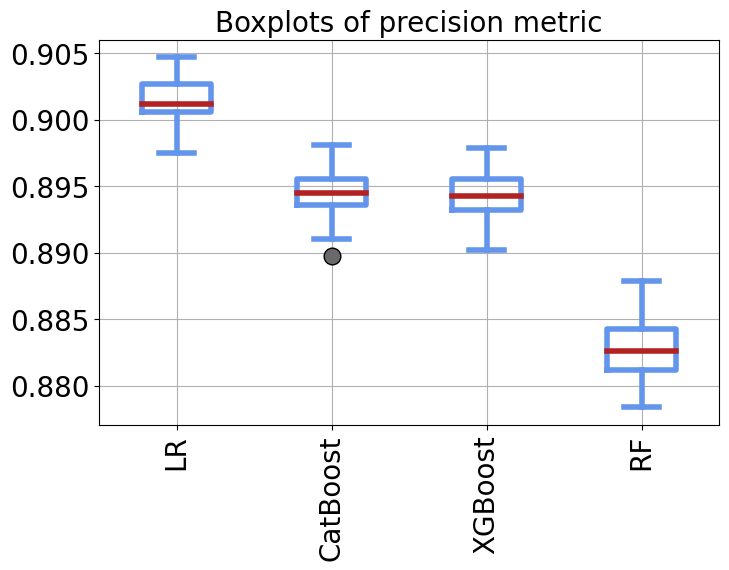

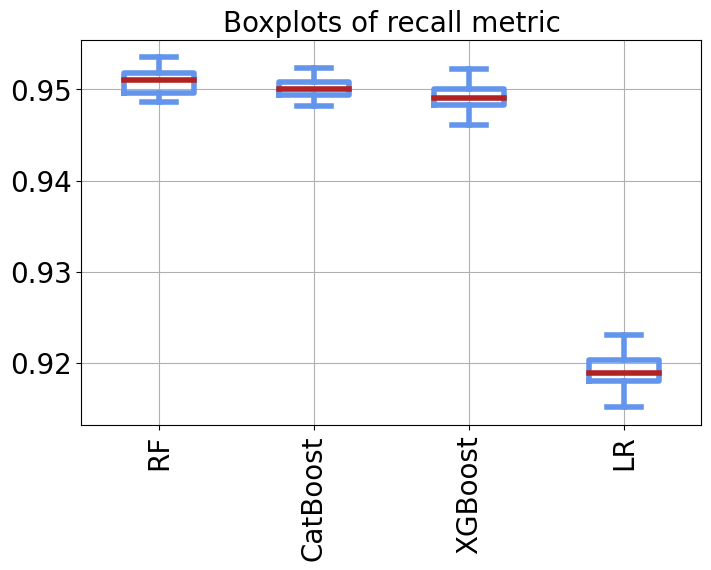

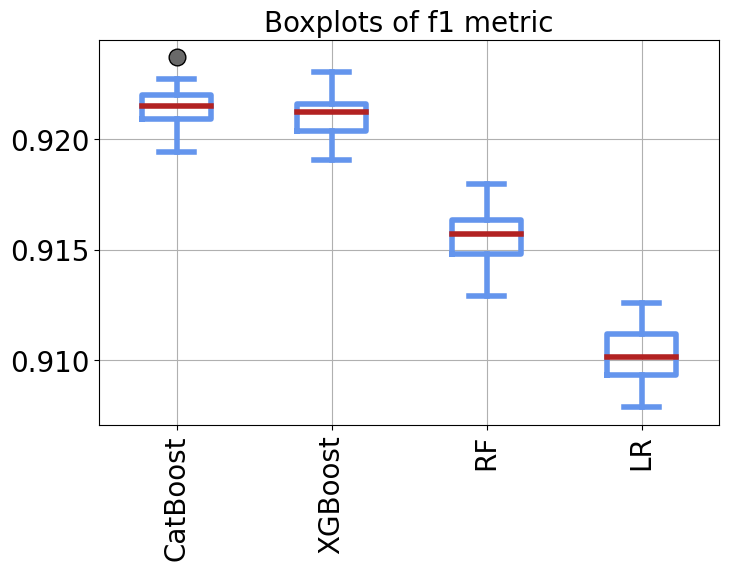

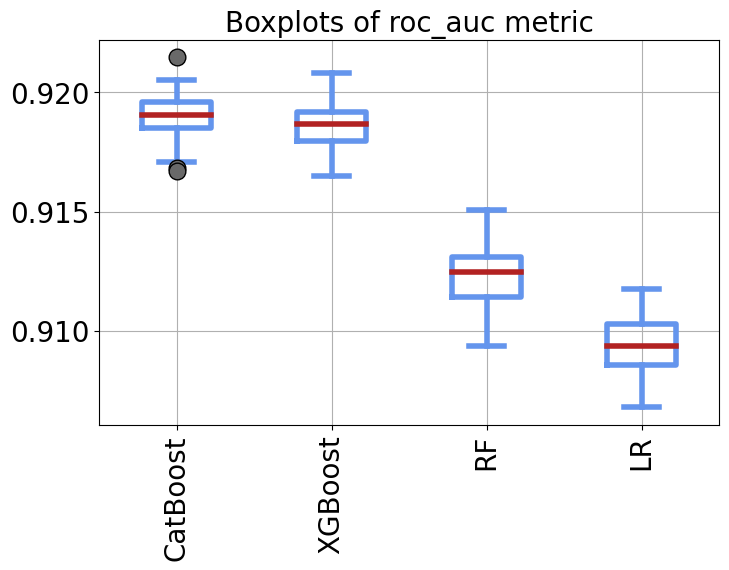

In [71]:
# Plota bloxpot das métricas
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
for metrica in metrics:
    boxplot_sorted(df_results, metrica, rot=90, figsize=(8,5), fontsize=20)


# Método SHAPley

### Melhor Classificador

In [72]:
name_best_clf = "CatBoost"
best_clf = list(filter(lambda m: m.get_name() == name_best_clf, best_clfs))[0]

### Remover variáveis redundantes

In [73]:
# Remove variaveis redudantes
# Obtém colunas com _Nao ou _M
columns_names = [col for col in covid_df.columns if "_2" in col or "_2.0" in col]
covid_df.drop(columns=columns_names, inplace=True)

In [74]:
def remover_text_in_column(df):
    for coluna in df.columns:
        if coluna.endswith("_1"):
            df.rename(columns={coluna: coluna.replace("_1", "")}, inplace=True)
        elif coluna.endswith("_1.0"):
            df.rename(columns={coluna: coluna.replace("_1.0", "")}, inplace=True)

    return df

In [75]:
covid_df = remover_text_in_column(covid_df)

### Funções auxiliares

In [76]:
def run_model(clf_model, X, y, test_size, balanced=True):
    # Balanceia os dados quano necessário
    if balanced:
        rus = RandomUnderSampler(sampling_strategy='majority')
        X, y = rus.fit_resample(X, y)

    # Split dos dados
    X_train, X_test, \
    y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)

    # Realiza o fit do modelo
    clf_model.fit(X_train, y_train.values.ravel())
    y_pred = clf_model.predict(X_test)

    # Calcula a acurácia
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

def shap_analysis(clf_model, X):
    # Gera o Tree explainer e SHAP values
    explainer = shap.TreeExplainer(clf_model)
    shap_values = explainer.shap_values(X)
    shap_obj    = explainer(X)
    expected_value = explainer.expected_value

    return shap_values, shap_obj

def summary_plot(shap_values, X, figname, plot_type="dot"):
    # Gera summary dot plot
    shap.summary_plot(shap_values, X, title="SHAP summary plot", show=False, plot_type=plot_type)

    # Gera summary bar plot
    plt.savefig(figname, format='pdf', dpi=600, bbox_inches='tight')
    plt.show()

### SHAP - Análises individuais

In [77]:
def generate_summary_plots(best_clf, X, y, test_size=0.20, n_times=10,
                           fileprefix='shap_summary_plot', filesuffix='', balanced=True):

    # Prefixo do arquivo
    date_time = datetime.now().strftime('%Y%m%d_%H%M%S')
    fileprefix = f'{fileprefix}_{date_time}'

    for i in range(n_times):
        
        # Reinicializa melhor modelo
        clf_model = best_clf.init_model()
        
        # Calcula acurácia
        accuracy = run_model(clf_model, X, y, test_size, balanced)

        # Realiza a análise shap
        shap_values, shap_obj = shap_analysis(clf_model, X)

        # Salva arquivo e plota figura
        figname = f'{fileprefix}_{filesuffix}_{i}_{int(accuracy*100)}.pdf'
        summary_plot(shap_values, X, figname)
        
def run_separated_shaps(df, fileprefix,
                        best_clf,
                        test_size=0.25, n_times=10, balanced=True):

    # Define características e alvo
    X  = df.drop(columns='PASSED')
    y  = df['PASSED'].to_frame()
    
    filesuffix = f'{best_clf.get_name()}'

    generate_summary_plots(best_clf, X, y,
                            test_size=test_size, n_times=n_times,
                            fileprefix=fileprefix, filesuffix=filesuffix, balanced=balanced)

In [78]:
fileprefix_separated = "./results/mx_shap_separated"
run_separated_shaps(covid_df, fileprefix_separated, best_clf, n_times=5, balanced=False)

### SHAP - Análises Acumuladas

In [79]:
def generate_consolidated_summary_plots(clf_model, df, filename="consolidated_shap", n_splits=5, n_repeats=10, balanced=True):
    
    # Define características e alvo
    X = df.drop(columns='PASSED')
    y = df['PASSED'].to_frame()
    
    # Balanceia quando necessário
    if balanced:
        rus = RandomUnderSampler(sampling_strategy='majority')
        X, y = rus.fit_resample(X, y)
    
    columns = X.columns

    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)

    list_shap_values = []
    list_test_sets = []
    list_accuracy = []

    for train_index, test_index in cv.split(X,y):
        
        # Obtem as divisões
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Treina modelo
        clf_model.fit(X_train, y_train.values.ravel())

        # Calcula acurácia
        y_pred   = clf_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        list_accuracy.append(accuracy)

        # Gera a explicabilidade do modelo
        explainer   = shap.TreeExplainer(clf_model)
        shap_values = explainer.shap_values(X_test)

        # Para cada iteração é salvo o test_set index e o shap_values
        list_shap_values.append(shap_values)
        list_test_sets.append(test_index)
        
    test_set = list_test_sets[0]
    shap_values = np.array(list_shap_values[0])

    for i in range(1, len(list_test_sets)):
        test_set    = np.concatenate((test_set, list_test_sets[i]),axis=0)
        shap_values = np.concatenate((shap_values, np.array(list_shap_values[i])),axis=0)


    # Retorna os nomes das variáveis
    X_test = pd.DataFrame(X.iloc[test_set],columns=columns)

    # Calcula média
    mean_accuracy = statistics.mean(list_accuracy)

    # Gera gráfico e salva em arquivo
    figname = f'{filename}_{int(mean_accuracy*100)}.pdf'
    summary_plot(shap_values, X_test, figname, plot_type='violin')


In [80]:
def run_consolidated_shaps(df, best_clf, fileprefix='shap_summary_plot', balanced=True):

    date_time = datetime.now().strftime('%Y%m%d_%H%M%S')
    fileprefix = f'{fileprefix}_{date_time}'

    clf = best_clf.init_model()

    generate_consolidated_summary_plots(clf, df, filename, n_splits=5, n_repeats=10, balanced = balanced)

Learning rate set to 0.417903
0:	learn: 0.2086589	total: 35.4ms	remaining: 14.1s
1:	learn: 0.1503473	total: 69.1ms	remaining: 13.7s
2:	learn: 0.1350628	total: 103ms	remaining: 13.6s
3:	learn: 0.1260392	total: 137ms	remaining: 13.6s
4:	learn: 0.1216918	total: 169ms	remaining: 13.4s
5:	learn: 0.1201865	total: 205ms	remaining: 13.4s
6:	learn: 0.1189921	total: 234ms	remaining: 13.1s
7:	learn: 0.1175673	total: 263ms	remaining: 12.9s
8:	learn: 0.1168846	total: 296ms	remaining: 12.8s
9:	learn: 0.1166104	total: 328ms	remaining: 12.8s
10:	learn: 0.1145178	total: 355ms	remaining: 12.6s
11:	learn: 0.1136785	total: 392ms	remaining: 12.7s
12:	learn: 0.1134314	total: 423ms	remaining: 12.6s
13:	learn: 0.1130683	total: 452ms	remaining: 12.5s
14:	learn: 0.1125790	total: 490ms	remaining: 12.6s
15:	learn: 0.1123750	total: 516ms	remaining: 12.4s
16:	learn: 0.1121794	total: 545ms	remaining: 12.3s
17:	learn: 0.1120166	total: 577ms	remaining: 12.3s
18:	learn: 0.1114231	total: 610ms	remaining: 12.2s
19:	learn

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


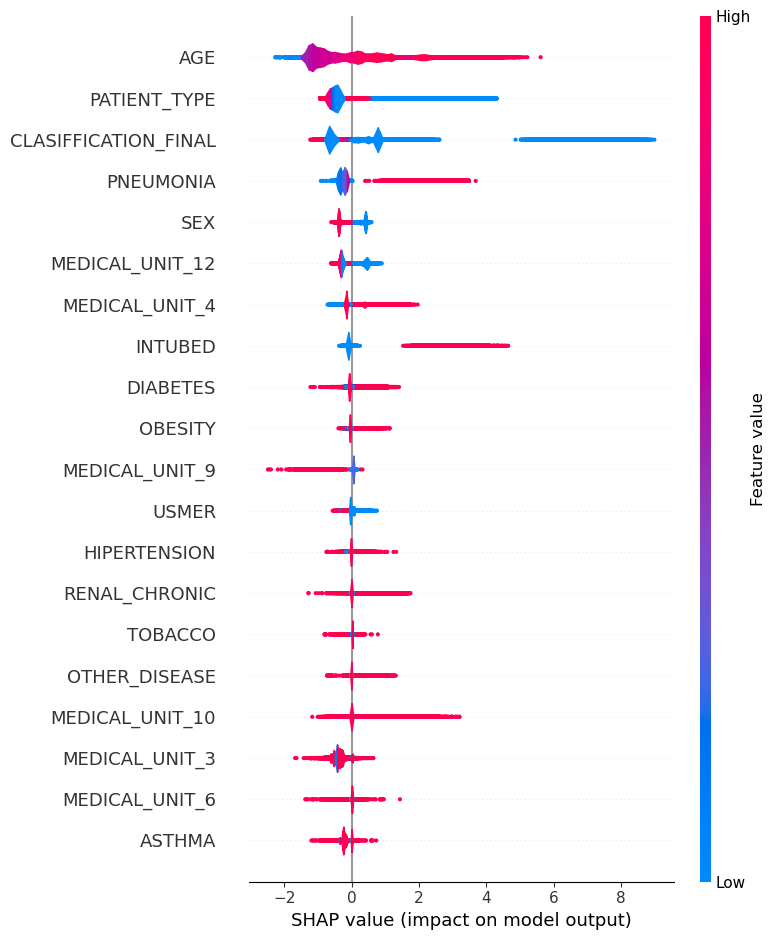

In [81]:
fileprefix = f'./results/mx_shap_consolidated'
run_consolidated_shaps(covid_df, best_clf,fileprefix=fileprefix, balanced=False)

### SHAP - Análise Local

In [82]:
def watter_fall(shap_obj, figname):
    # Unica obervacao
    print(shap_obj[0])
    shap.plots.waterfall(shap_obj[0])

    # Gera water fall plot
    plt.savefig(figname, format='pdf', dpi=600, bbox_inches='tight')
    plt.show()

def generate_single_observation_watter_fall(df, best_clf, test_size=0.2, filesuffix="shap_single_observation", balanced=True):    
    # Reinicia modelo
    clf_model = best_clf.init_model()
    
    y = df.PASSED
    X = df.drop(columns=["PASSED"], axis=1)
    
    # Balanceia os dados
    if balanced:
        rus = RandomUnderSampler(sampling_strategy='majority')
        X, y = rus.fit_resample(X, y)
    
    # Split dos dados
    X_train, X_test,\
    y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)

    # Calcula acurácia
    accuracy = run_model(clf_model, X, y, test_size)

    # Análise SHAP
    shap_values, shap_obj = shap_analysis(clf_model, X)

    figname = f'{fileprefix}_{filesuffix}_{i}_{int(accuracy*100)}.pdf'

    watter_fall(shap_obj, figname)

Learning rate set to 0.18257
0:	learn: 0.5119911	total: 23.7ms	remaining: 9.47s
1:	learn: 0.4155930	total: 35.7ms	remaining: 7.11s
2:	learn: 0.3550728	total: 47.1ms	remaining: 6.24s
3:	learn: 0.3173980	total: 56.7ms	remaining: 5.62s
4:	learn: 0.2944445	total: 67.1ms	remaining: 5.3s
5:	learn: 0.2808168	total: 78.6ms	remaining: 5.16s
6:	learn: 0.2710156	total: 89ms	remaining: 5s
7:	learn: 0.2613114	total: 99.3ms	remaining: 4.87s
8:	learn: 0.2553820	total: 110ms	remaining: 4.77s
9:	learn: 0.2498909	total: 120ms	remaining: 4.67s
10:	learn: 0.2468156	total: 131ms	remaining: 4.63s
11:	learn: 0.2444834	total: 140ms	remaining: 4.54s
12:	learn: 0.2416420	total: 150ms	remaining: 4.48s
13:	learn: 0.2399280	total: 160ms	remaining: 4.42s
14:	learn: 0.2376063	total: 171ms	remaining: 4.39s
15:	learn: 0.2364382	total: 182ms	remaining: 4.38s
16:	learn: 0.2349107	total: 194ms	remaining: 4.38s
17:	learn: 0.2336445	total: 207ms	remaining: 4.4s
18:	learn: 0.2326652	total: 218ms	remaining: 4.37s
19:	learn: 

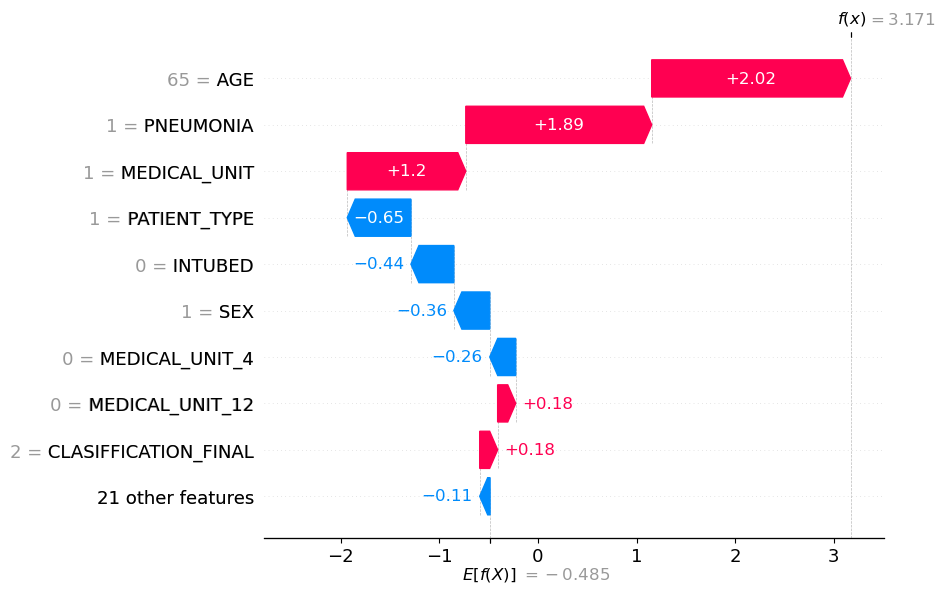

<Figure size 640x480 with 0 Axes>

In [83]:
generate_single_observation_watter_fall(covid_df, best_clf, balanced=False)